In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import semisupervised_vae_lib as ss_vae_lib

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib


In [3]:
seed = 13423
np.random.seed(seed)
_ = torch.manual_seed(seed)


# Load data

In [4]:
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(propn_sample=0.001, 
                                                      propn_labeled = 0.1)

| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified


In [5]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  5
num_train_unlabled:  45
num_test:  10


In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labels_legend_all = unpickle('../cifar100_data/cifar-100-python/meta')
fine_labels_legend = labels_legend_all[b'fine_label_names']

In [7]:
def plot_cifar_image(image, label):
    image_unscaled = image * cifar_data_utils.CIFAR_STD_TENSOR + cifar_data_utils.CIFAR_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    plt.imshow(img)
    plt.title(fine_labels_legend[label])

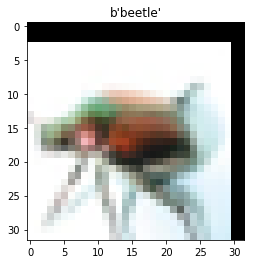

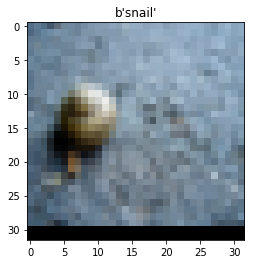

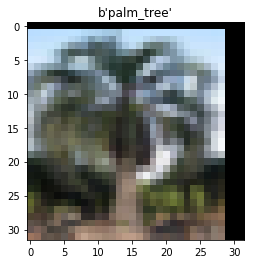

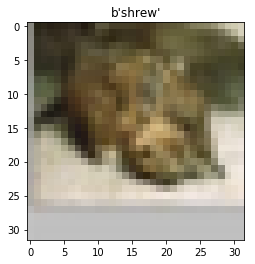

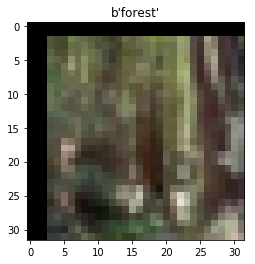

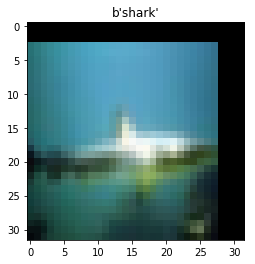

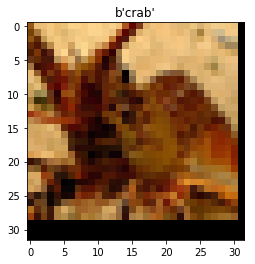

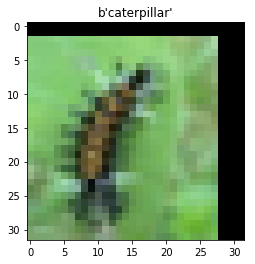

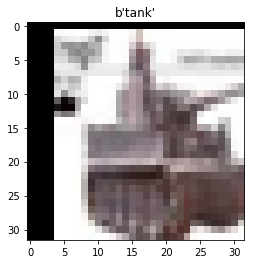

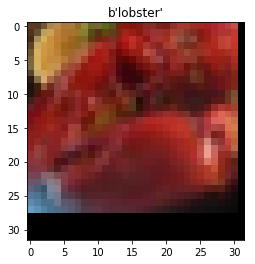

In [8]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(train_set_unlabeled[i]['image'].squeeze(), train_set_unlabeled[i]['label'])

In [9]:
slen = train_set_labeled[0]['image'].shape[-1]

# Get data loaders

In [10]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=train_set_labeled.num_images,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [11]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [12]:
data_unlabeled['image'].shape

torch.Size([12, 3, 32, 32])

In [13]:
data_labeled['image'].shape

torch.Size([5, 3, 32, 32])

In [14]:
data_test['image'].shape

torch.Size([10, 3, 32, 32])

# Define VAE

In [15]:
image_config = {'slen': 32,
                 'channel_num': 3,
                 'n_classes': 100}

cond_vae_config = {'kernel_num': 5,
                   'z_size': 2}

classifier_config = {'depth': 10,
                     'widen_factor': 2,
                     'dropout_rate': 0.3}

In [16]:
cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

| Wide-Resnet 10x2


## check conditional vae

In [17]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])

In [18]:
image_mean.shape

torch.Size([12, 3, 32, 32])

In [19]:
latent_means.shape

torch.Size([12, 2])

In [20]:
latent_std.shape

torch.Size([12, 2])

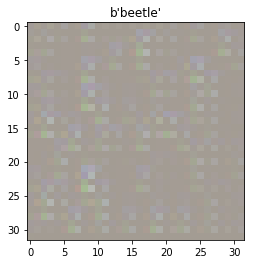

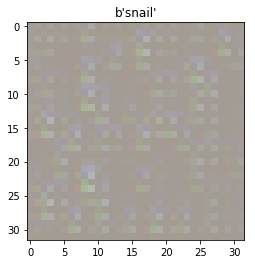

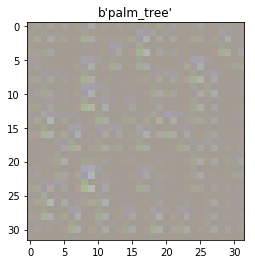

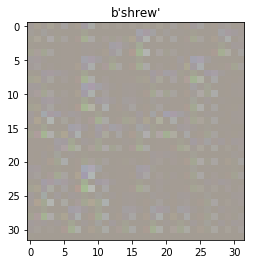

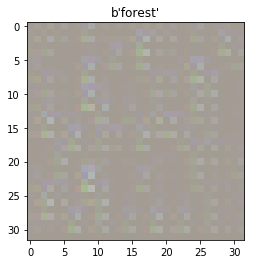

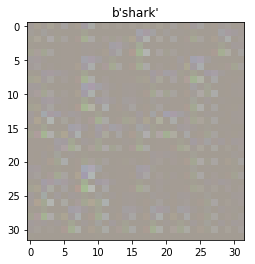

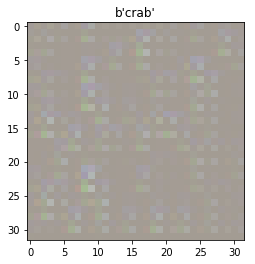

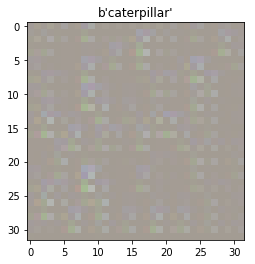

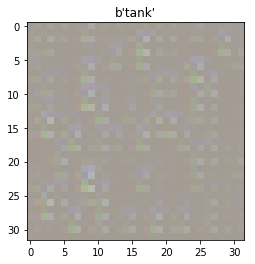

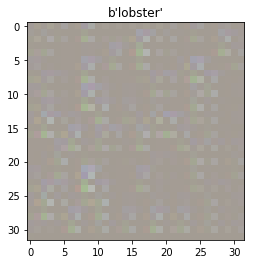

In [21]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

### check classifier

In [22]:
log_q = cifar_vae.classifier.forward(data_unlabeled['image'])

In [23]:
assert np.all(log_q.detach().numpy() < 0)

In [24]:
print(log_q.shape)

torch.Size([12, 100])


In [25]:
# check loss goes through

In [28]:
cond_loss = cifar_vae.get_conditional_loss(data_unlabeled['image'], data_unlabeled['label'])

In [29]:
assert len(cond_loss) == len(data_unlabeled['label'])

In [31]:
cond_loss

tensor([-31149.7910, -31149.7910, -31149.7910, -31149.7891, -31149.7891,
        -31149.7910, -31149.7910, -31149.7910, -31149.7910, -31149.7910,
        -31149.7891, -31149.7910])

In [33]:
cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(-3.1327e+07), tensor(1.00000e+05 *
        -3.7566))

# Check gradient works 

In [34]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [35]:
vae_params0 = get_vae_params(cifar_vae)

In [36]:
assert np.any(np.isnan(vae_params0)) == False

In [38]:
optimizer = optim.Adam(cifar_vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [39]:
loss, map_loss1 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(1.00000e+05 *
       -3.7502)


In [40]:
loss.backward()
optimizer.step()

In [41]:
vae_params1 = get_vae_params(cifar_vae)

In [42]:
assert np.any(np.isnan(vae_params1)) == False

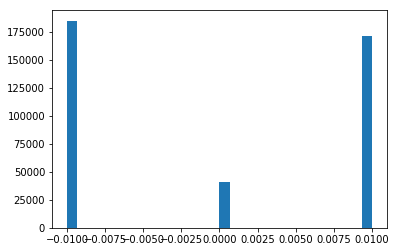

In [43]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [44]:
loss, map_loss2 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [45]:
map_loss2

tensor(1.00000e+05 *
       -3.8830)

In [46]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [47]:
from torch.utils.data.sampler import Sampler

In [48]:
ss_vae_lib.train_semisupervised_model(cifar_vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = False)

  * init train recon loss: -24952.5;
  * init test recon loss: -21704.73438;


RuntimeError: mean is not implemented for type torch.ByteTensor

In [38]:
torch.exp(vae.classifier(data_unlabeled['image']).detach())

tensor([[ 0.1099,  0.0681,  0.1200,  0.0951,  0.1012,  0.0927,  0.0826,
          0.1464,  0.0980,  0.0861],
        [ 0.1132,  0.0704,  0.1143,  0.0953,  0.1009,  0.0858,  0.0869,
          0.1486,  0.0990,  0.0856],
        [ 0.1114,  0.0691,  0.1144,  0.0969,  0.0994,  0.0859,  0.0913,
          0.1473,  0.0998,  0.0846],
        [ 0.1110,  0.0690,  0.1163,  0.0962,  0.1005,  0.0882,  0.0877,
          0.1472,  0.0983,  0.0855],
        [ 0.1114,  0.0687,  0.1159,  0.0962,  0.1003,  0.0887,  0.0871,
          0.1480,  0.0985,  0.0853],
        [ 0.1150,  0.0663,  0.1162,  0.0951,  0.0995,  0.0845,  0.0850,
          0.1570,  0.0992,  0.0822],
        [ 0.1130,  0.0678,  0.1163,  0.0945,  0.0992,  0.0859,  0.0875,
          0.1519,  0.0987,  0.0850],
        [ 0.1117,  0.0691,  0.1136,  0.0955,  0.0982,  0.0872,  0.0929,
          0.1478,  0.1010,  0.0831],
        [ 0.1142,  0.0674,  0.1186,  0.0939,  0.1013,  0.0850,  0.0844,
          0.1548,  0.0967,  0.0838],
        [ 0.1139,  

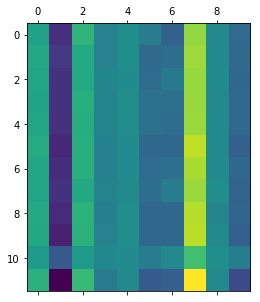

In [39]:
plt.matshow(vae.classifier(data_unlabeled['image']).detach())

In [40]:
# check reloading

In [43]:
reload_vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)


# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

In [44]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [45]:
reload_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

tensor(433.1495)

In [48]:
recon_mean, _ =  ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

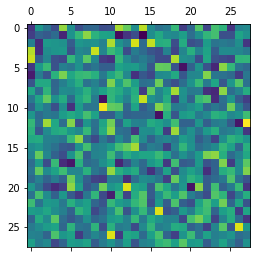

In [49]:
plt.matshow(recon_mean[3, :, :].detach())